# Furijeove transformacije $-$ obrada zvuka

U ovom primeru ćemo raditi sa zvučnim signalom i upoznati se sa tehnikom kreiranja spektrograma, jedinstvenog zvučnog zapisa. 

In [196]:
from IPython import display
from scipy.io import wavfile

In [197]:
import numpy as np
from numpy import fft
from matplotlib import pyplot as plt

Koristeći audio funkcionalnosti Jupyter sveski, poslušajmo najpre *bonobo.wav* snimak koji ćemo koristiti u radu.

In [198]:
display.Audio(url='data/bonobo.wav')

Dalje ćemo pročitati podatke sadržane u ovaj audio datoteci korišenjem funkcije `read` paketa `wavfile`. Rezultat čitanja su frekvencija uzorkovanja i sami uzorci. 

In [199]:
Fs, data = wavfile.read('data/bonobo.wav')

In [200]:
print('Frekvencija uzorkovanja: ', Fs)
print('Uzorci: ', data.shape)

Frekvencija uzorkovanja:  44100
Uzorci:  (1323000, 2)


Iz forme pročitanih audio uzoraka možemo da zaključimo da je u pitanju dvokanalni stereo zvuk. Možemo odrediti aritmetičku sredinu uzoraka kako bismo dobili jednodimenzioni signal. 

In [201]:
data = data.mean(axis=1)

In [202]:
data

array([ 1880.5,  1505. ,   797.5, ..., -7149.5, -6900. , -7005. ])

In [203]:
print('Uzorci: ', data.shape)

Uzorci:  (1323000,)


Broj uzoraka ćemo obeležiti sa $N$.

In [204]:
N = data.shape[0]
N

1323000

Možemo dalje da odredimo ukupno trajanje audio snimka.

In [205]:
duration = N / Fs # number of all samples divided by frequency(number of the samples recorded in 2 sec) 
duration

30.0

In [206]:
Fs//2

22050

Pošto su audio zapisi bogati frekvencijama, razmotrimo kako se zvuk ponaša u prvih pola sekunde. 

Odredimo najpre broj uzoraka u prvih pola sekunde i izdojimo ih.

In [207]:
# Fs - giving us numbers of sample by a secound. For one sec we extract Fs samples
# Now we created the variable which is correlated to the number of samples which we need for the half-second
N = Fs // 2 
print(N)
sample = data[:N] # From our data, we sliced elements that are corresponded to the first half of second
sample

22050


array([ 1880.5,  1505. ,   797.5, ..., -1046.5, -2734. , -3865. ])

In [208]:
# now we just check duration of file
#duration = N / Fs
#duration

In [209]:
#int(N)/int(n)

Potom prikažimo spektar magnituda.

In [210]:
c = fft.fft(sample)
#print(c)
freq = fft.fftfreq(N, 1.0/Fs)

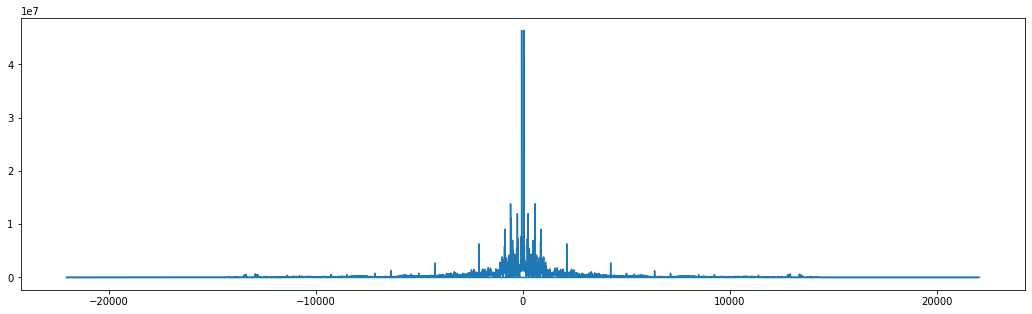

In [211]:
plt.figure(figsize=(18,5))
plt.plot(freq, np.abs(c))

plt.show()

Možemo dalje redukovati skup frekvencija na interval $(0, 1000)$. To možemo postići kreiranjem odgovarajuće maske i izborom odgovarajućih koeficijenata i frekvencija.

In [224]:
mask = (freq > 0) & (freq < 1000) # frekvencije duz x -ose
c_filtered = c[mask]
freq_filtered = freq[mask]
len(freq_filtered)

499

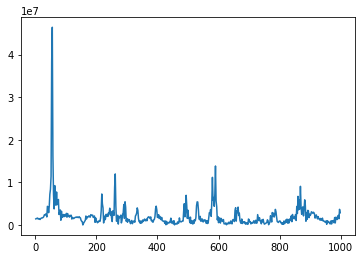

In [213]:
plt.plot(freq_filtered, np.abs(c_filtered))
plt.show()

<StemContainer object of 3 artists>

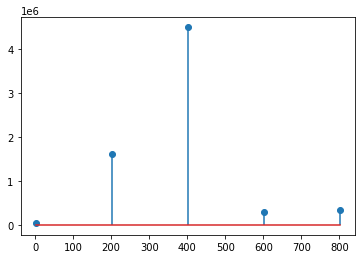

In [231]:
plt.stem(freq_filtered[::100],np.abs(c_filtered[::100]))

### Prozorske funkcije

Pre nego li kreiramo spektrogram, uvedimo pojam prozorskih funkcija (eng. *window functions*). Ove funkcije obično imaju formu zvona i primarni cilj da pojačaju i unaprede vrednosti signala. Kako na krajevima intervala prozorske funkcije uzimaju vrednosti bliske nulama, mogu preduprediti problem curenja spektra koji nastaje prilikom rada sa signalima koji nisu periodični. Na nivou paketa `signal` podržane su Blakmanova, Hanova, Hamingova i mnoge druge prozorske funkcije.

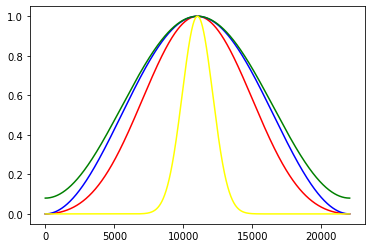

In [232]:
from scipy import signal

plt.plot(np.arange(0,n), signal.windows.blackman(n), color='red')
plt.plot(np.arange(0,n), signal.windows.hann(n), color='blue')
plt.plot(np.arange(0,n), signal.windows.hamming(n), color='green')
# promeniti parametar Kajzerove funkcije i videti kako se signal ponasa
plt.plot(np.arange(0,n), signal.windows.kaiser(n, 100), color='yellow')
plt.show()

Za naš primer ćemo uzeti npr. Kajzerovu prozorsku funkciju sa parametrom 5.

In [233]:
window = signal.windows.kaiser(n, 5)

### Spektrogram

Sada ćemo kreirati spektrogram. Spektrogram predstavlja vizuelnu reprezantaciju zvučnog signala u frekvencijskom domenu. Ovde će on biti predstavljen matricom čiji:
- __broj redova__ odgovara broju isečaka dužine 0.5 i onoliko __kolona__ koliko ima frekvencija frekvencijskog domena koje se prate. 

In [237]:
sp_frequencies = freq_filtered.shape[0]
print(sp_frequencies)
print(duration)
sp_time = int(duration // 0.5) # how many we have slices with the lenght 0.5

spectrogram = np.zeros((sp_time, sp_frequencies))# we created a zeros matrix
spectrogram.shape

499
30.0


(60, 499)

Prethodno smo razmotrili frekvencijsku strukturi zvučnog zapisa u prvih 0.5 sekundi. __*Sada ćemo proći kroz sve vremenske isečke dužine 0.5 sekundi*__ i nad njima ponoviti opisani postupak tj. popraviti signal prozorskom funkcijom, primeniti Furijeovu transformaciju, izračunati vrednosti magnituda, a zatim ih i sačuvati u spektrogramu.

In [238]:
for i in range(0, sp_time):
    samples = data[i*n : (i+1)*n] # pratimo svaki isecak od 0.5 sekundi i izvlacimo semplove iz tog opsega
    c = fft.fft(samples* window) 
    c_filtered = c[mask]
    values = np.log(np.abs(c_filtered))
    spectrogram[i, :] = values

Prikažimo sada spektrogram.

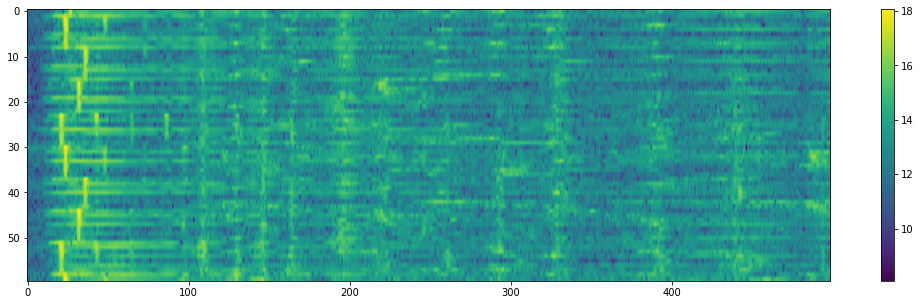

In [242]:
plt.figure(figsize=(18,5))
plt.imshow(spectrogram, aspect='auto')

plt.colorbar()
plt.show()
#plt.xlabel("Frequency")
#plt.ylabel("time")

Pošto se spektrogrami jako često koriste u obradi zvuka, postoji i ugrađena bibliotečka podrška preko funkcije `spectrogram`. Povratne vrednosti funkcije su: niz frekvencija prisutnih u zapisu (f), niz vremena koji određuje segmente (t) i vrednosti spektrograma (s).

In [240]:
f, t, s = signal.spectrogram(data, Fs)

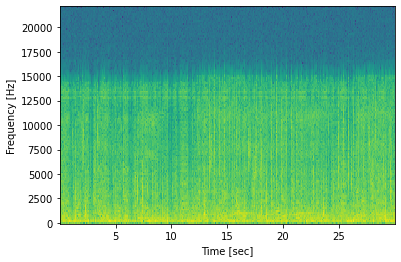

In [221]:
plt.pcolormesh(t, f, np.log(s),shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()